# Training simple multilayer percepton (MLP) on the MNIST dataset

Notes:
    * Adaptive learning was not working in that case, probably because of the noise of the gradient between batches. 
    * Normalizing by Lmax seems to be the best working optimizer for me.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow as tf
tf.__version__

'1.7.0'

In [3]:
import sys
sys.path.append("../src/")
import keras_mnist_mlp as mlp
import tf_optimizer as tf_opt
import callbacks as clb
import utils as ut
from plotting import set_display_settings
set_display_settings()

from keras.optimizers import TFOptimizer
from keras.callbacks import History

Using TensorFlow backend.


## Dataset and model definition

In [5]:
x_train, y_train, validation_set, input_shape = mlp.get_dataset()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model function:
    * 30 dense layers of size 128. 
    * After each layer Batchnormalization is applied then dropout at level 0.2
    * Small l2 regularization is added to the weights of the network

In [6]:
def model_fn():
    model = mlp.get_mlp(num_layers=30, lantent_size=128, activation='relu', l2_reg=1e-5)
    return model

model = model_fn()
batch_size = 64

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Train model with `LmaxNormalizedSGD`

Some notes: 

* `LmaxNormalizedSGD` just normalizes gradients by their $L_\infty$ norm for each layer.
* No momentum is used, since it did not improve results for this case..

In [8]:
model = model_fn()
metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = TFOptimizer(tf_opt.LmaxNormalizedSGD(lr=lr))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=batch_size, epochs=10, 
        validation_data=validation_set, 
        callbacks=metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/step - loss: 1.9599 - acc: 0.3057 - val_loss: 0.9577 - val_acc: 0.7149
Epoch 2/10
60000/60000 [==============================] - 58s 973us/step - loss: 0.9923 - acc: 0.6834 - val_loss: 0.6909 - val_acc: 0.7533
Epoch 3/10
60000/60000 [==============================] - 60s 992us/step - loss: 0.8890 - acc: 0.7118 - val_loss: 0.6665 - val_acc: 0.7535
Epoch 4/10
60000/60000 [==============================] - 59s 981us/step - loss: 0.8356 - acc: 0.7171 - val_loss: 0.7123 - val_acc: 0.7410
Epoch 5/10
60000/60000 [==============================] - 59s 982us/step - loss: 0.8447 - acc: 0.7129 - val_loss: 0.6464 - val_acc: 0.7510
Epoch 6/10
60000/60000 [==============================] - 58s 971us/step - loss: 0.8023 - acc: 0.7241 - val_loss: 0.5899 - val_acc: 0.7699
Epoch 7/10
60000/60000 [==============================] - 58s 971us/step - loss: 0.8069 - acc: 0.7275 - val_loss: 0.59

Plotting:

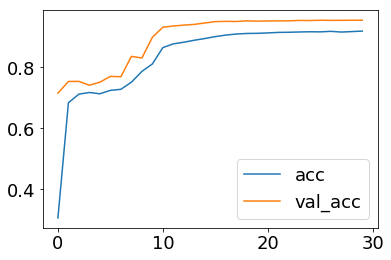

In [9]:
hist = metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with Adam optimizer and SGD with momentum (0.9)

For Adam I use slightly smaller learning rate since it was perfoming better for me. Propably one could get better results by doing grid search on the initial value of `lr`.

In [10]:
from keras.optimizers import Adam, SGD

In [11]:
model = model_fn()
optimizer = Adam(lr=0.001)
adam_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]
# lr=0.01 was not training properly, the validation loss was dropping after some epochs
for lr in [0.005, 0.001, 0.0001]:
    optimizer = Adam(lr=lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=batch_size, epochs=10, 
        validation_data=validation_set, 
        callbacks=adam_metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 90s 1ms/step - loss: 2.0504 - acc: 0.2595 - val_loss: 1.2865 - val_acc: 0.4526
Epoch 2/10
60000/60000 [==============================] - 75s 1ms/step - loss: 1.3600 - acc: 0.4633 - val_loss: 0.9709 - val_acc: 0.6040
Epoch 3/10
60000/60000 [==============================] - 75s 1ms/step - loss: 1.1702 - acc: 0.5766 - val_loss: 0.8958 - val_acc: 0.7310
Epoch 4/10
60000/60000 [==============================] - 75s 1ms/step - loss: 1.0883 - acc: 0.6763 - val_loss: 0.7079 - val_acc: 0.7954
Epoch 5/10
60000/60000 [==============================] - 75s 1ms/step - loss: 0.9966 - acc: 0.7218 - val_loss: 0.8389 - val_acc: 0.7464
Epoch 6/10
60000/60000 [==============================] - 74s 1ms/step - loss: 1.0698 - acc: 0.6845 - val_loss: 0.9057 - val_acc: 0.7005
Epoch 7/10
60000/60000 [==============================] - 76s 1ms/step - loss: 1.0656 - acc: 0.6922 - val_loss: 1.0014 - val_acc

In [ ]:
hist = adam_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with SGD and momentum

In [13]:
from keras.optimizers import SGD
model = model_fn()
momentum_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = SGD(lr=lr,  momentum=0.9)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=batch_size, epochs=10, 
        validation_data=validation_set, 
        callbacks=momentum_metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 76s 1ms/step - loss: 3.4554 - acc: 0.1575 - val_loss: 2.9794 - val_acc: 0.3375
Epoch 2/10
60000/60000 [==============================] - 60s 1ms/step - loss: 3.1412 - acc: 0.2714 - val_loss: 2.7139 - val_acc: 0.3999
Epoch 3/10
60000/60000 [==============================] - 60s 995us/step - loss: 2.9245 - acc: 0.3416 - val_loss: 2.5496 - val_acc: 0.4610
Epoch 4/10
60000/60000 [==============================] - 59s 990us/step - loss: 2.7775 - acc: 0.3907 - val_loss: 2.4371 - val_acc: 0.5015
Epoch 5/10
60000/60000 [==============================] - 60s 998us/step - loss: 2.6742 - acc: 0.4361 - val_loss: 2.2995 - val_acc: 0.6009
Epoch 6/10
60000/60000 [==============================] - 60s 992us/step - loss: 2.5833 - acc: 0.4779 - val_loss: 2.2160 - val_acc: 0.6099
Epoch 7/10
60000/60000 [==============================] - 59s 989us/step - loss: 2.5114 - acc: 0.5091 - val_loss: 2.1435

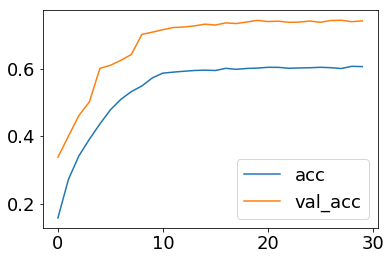

In [14]:
hist = momentum_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0:
        plt.plot(v, label=k)
plt.legend()

# Plots for comparison

In [16]:
hists = {
  'NSGD': metrics_history,
  'Adam': adam_metrics_history,
  'Momentum': momentum_metrics_history
} 

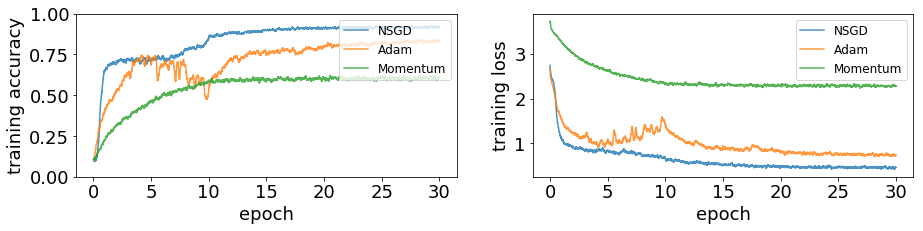

In [17]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[0].monitor_values['accuracies']['acc']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.ylim([0, 1])
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[0].monitor_values['losses']['loss']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.savefig('../img/mnist_mlp_training.pdf')
plt.savefig('../img/mnist_mlp_training.png')

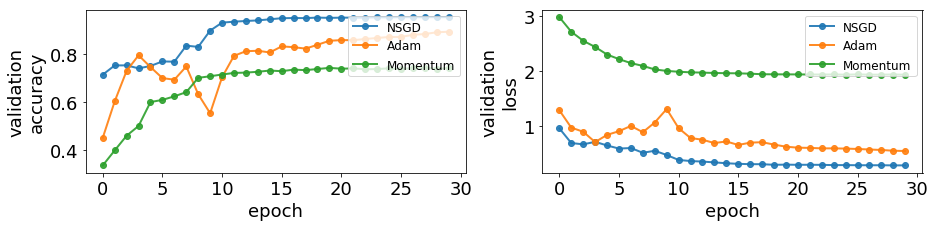

In [18]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[1].monitor_values['accuracies']['val_acc']
    plt.plot(h, 'o-',label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\naccuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[1].monitor_values['losses']['val_loss']
    plt.plot(h, 'o-', label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\nloss')
plt.savefig('../img/mnist_mlp_validation.pdf')
plt.savefig('../img/mnist_mlp_validation.png')